# Re Evaluate the data

In [2]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Load Data

In [3]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [4]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [5]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [6]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [7]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [8]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [9]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [38]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [10]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [10]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
964054,340807,0,Cash loans,M,Y,Y,1,270000.0,573408.0,36774.0,495000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.046220,-10338,-639,-5119.0,-3009,1,1,0,1,0,0,3.0,1,1,MONDAY,16,0,1,1,0,0,0,Business Entity Type 3,0.623417,1.0,0.0,1.0,0.0,0.0,NaN,NaN,1929018.0,Consumer loans,0.000,123925.5,123925.5,123925.5,FRIDAY,16.0,Y,1.0,XAP,Unused offer,-955.0,Cash through the bank,CLIENT,Repeater,Photo / Cinema Equipment,XNA,XNA,Country-wide,20.0,Connectivity,0.0,XNA,POS mobile with interest,0.0,NaN,NaN,NaN,NaN,NaN,NaN
277417,169487,0,Cash loans,M,Y,N,0,202500.0,360000.0,0.0,360000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.046220,-19762,-2498,-11285.0,-3305,1,1,1,1,1,0,1.0,1,1,FRIDAY,15,0,1,1,0,1,1,Other,0.583947,0.0,0.0,0.0,0.0,-743.0,1174500.000,877228.335,1781370.0,Revolving loans,0.000,0.0,0.0,0.0,SATURDAY,10.0,Y,1.0,XAP,Canceled,-378.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Card Street,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1377922,443250,0,Cash loans,M,Y,Y,0,99000.0,450000.0,31450.5,450000.0,Unaccompanied,Commercial associate,Incomplete higher,Civil marriage,House / apartment,0.008625,-15856,-1479,-2128.0,-1959,1,1,1,1,0,0,2.0,2,2,TUESDAY,15,0,0,0,0,1,1,Business Entity Type 3,0.532958,8.0,1.0,8.0,0.0,-241.0,732442.500,0.000,2353683.0,Cash loans,23496.705,225000.0,239850.0,225000.0,SATURDAY,12.0,Y,1.0,XNA,Approved,-66.0,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Country-wide,1000.0,Consumer electronics,12.0,low_normal,Cash X-Sell: low,-6.0,251608.095,251608.095,0.000,NaN,NaN,0.000000
1123943,379892,0,Cash loans,F,N,N,0,67500.0,175500.0,11556.0,175500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.015221,-15592,-7827,-7039.0,-3930,1,1,0,1,1,1,2.0,2,2,TUESDAY,16,0,0,0,0,0,0,Advertising,0.584505,0.0,0.0,0.0,0.0,-1090.0,1568349.000,1306214.460,1012349.0,Consumer loans,57330.315,324450.0,324450.0,324450.0,SATURDAY,15.0,Y,1.0,XAP,Approved,-724.0,Cash through the bank,XAP,Repeater,Clothing and Accessories,POS,XNA,Stone,100.0,Clothing,6.0,low_normal,POS industry with interest,-542.0,343851.120,343851.120,0.000,NaN,NaN,0.000000
138990,134756,0,Cash loans,F,N,Y,1,157500.0,953941.5,31657.5,823500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.009630,-13997,-623,-1110.0,-2260,1,1,0,1,0,0,2.0,2,2,TUESDAY,13,0,1,1,0,1,1,Business Entity Type 2,0.023188,8.0,0.0,7.0,0.0,-410.0,412992.

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


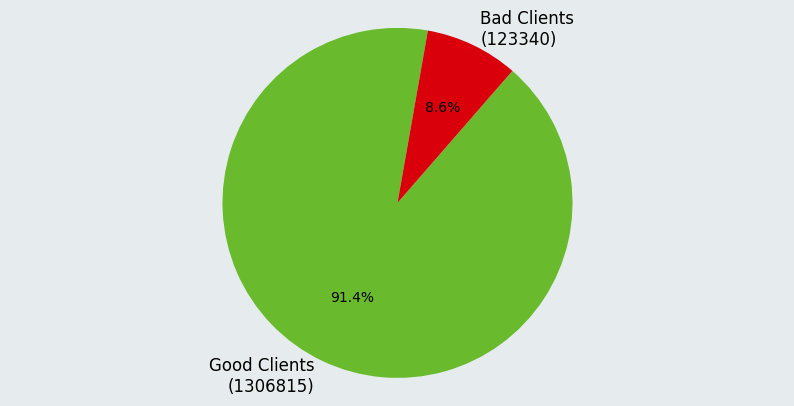

In [12]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()

As we can see that Clients in our data is Dominated by Good Clients whose don't have payment difficulties. This also mean that our data class is imbalance, we have to handle this imbalance data later on.

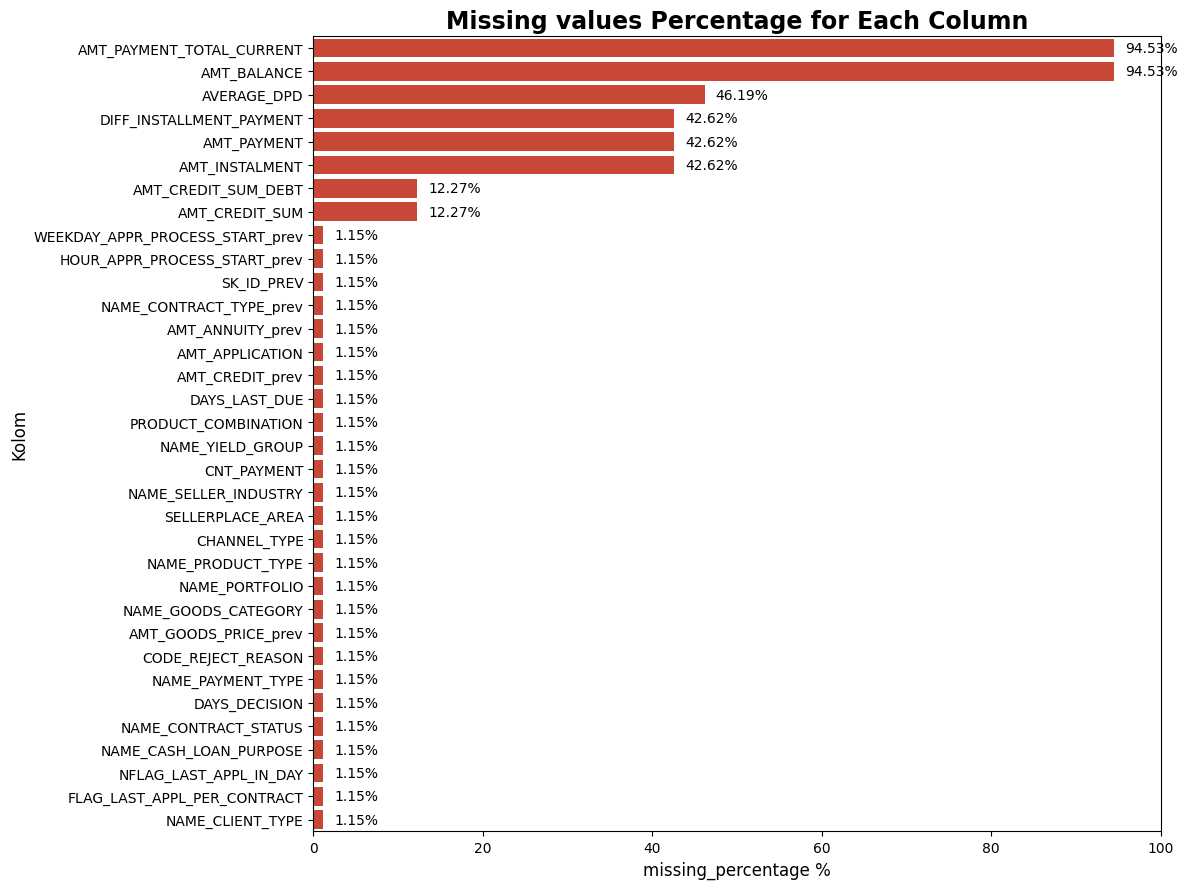

In [13]:
ms.plot_missing_percentage(train_full)

## Oulier Cheking

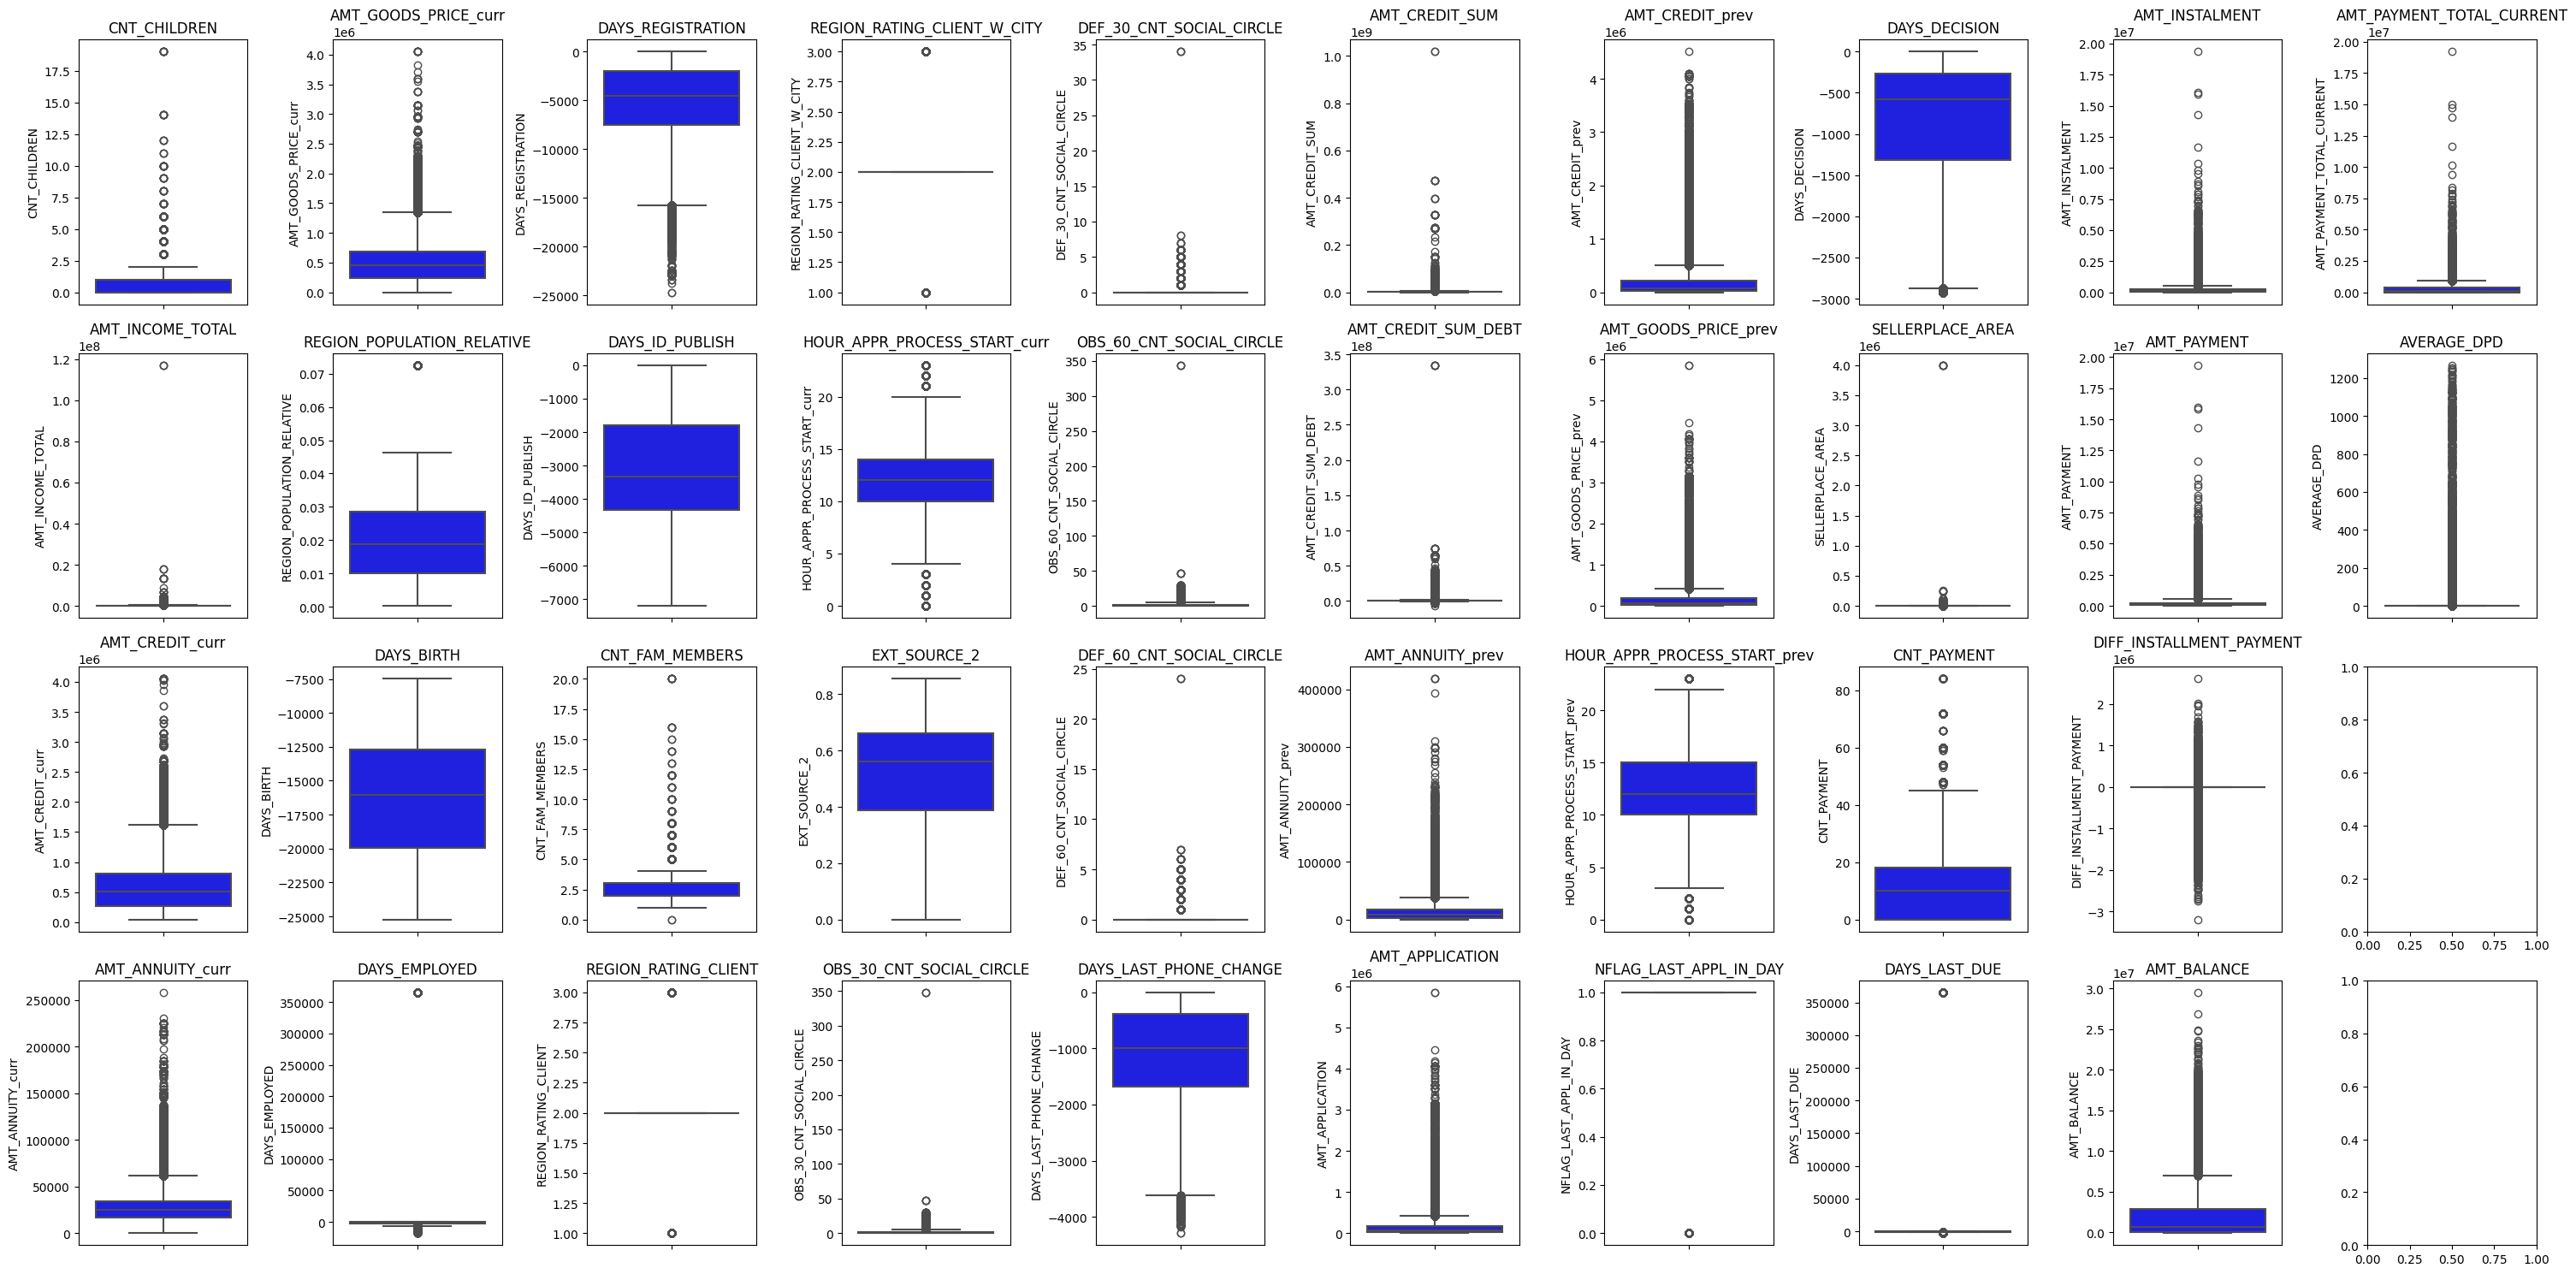

In [14]:
numvisual = train_full[[
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
    'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
    'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
    'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
    'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
    'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
    'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
    'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
    'AVERAGE_DPD'
          ]].copy()

colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# Create a 9x4 grid of subplots
fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# for each group of 4 columns
for i, group in enumerate(colgroup):
    # For eachg column in the group
    for j, column in enumerate(group):
        # Create a boxplot for the apporopriate subplot
        sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
        axs[j, i].set_title(column)

# show plot
plt.tight_layout()
plt.show()

## Train Test Split

In [39]:
X = train_full.drop(columns=['TARGET', 'SK_ID_CURR', 'SK_ID_PREV'], axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)


## Handle Missing Values

In [40]:
# X train missing values handling
X_train_c1 = X_train.AVERAGE_DPD.fillna(0)
X_train_c2 = ms.dropnan(X_train, 0.4)

train_missing = X_train_c2[X_train_c2.columns[X_train_c2.isna().any()]] 
traincol = train_missing.columns

for col in traincol:
    if X_train_c2[col].dtype == 'object':
        X_train_c2[col].fillna(X_train_c2[col].mode()[0], inplace=True)
    else:
        X_train_c2[col].fillna(X_train_c2[col].median(), inplace=True)


# X test missing values handling
X_test_c1 = X_test.AVERAGE_DPD.fillna(0)
X_test_c2 = ms.dropnan(X_test, 0.4)

test_missing = X_test_c2[X_test_c2.columns[X_test_c2.isna().any()]]
testcol = test_missing.columns

for col in testcol:
    if X_test_c2[col].dtype == 'object':
        X_test_c2[col].fillna(X_test_c2[col].mode()[0], inplace=True)
    else:
        X_test_c2[col].fillna(X_test_c2[col].median(), inplace=True)

## Handling Outlier

In [15]:
# def cap_outliers(data, columns):
#     # Create a copy of the data to avoid modifying the original DataFrame
#     result = data.copy()

#     # Loop over each column in the provided list
#     for col in columns:
#         # Calculate the first quartile (Q1) for the current column
#         Q1 = result[col].quantile(0.25)
#         # Calculate the third quartile (Q3) for the current column
#         Q3 = result[col].quantile(0.75)
#         # Calculate the Interquartile Range (IQR) for the current column
#         IQR = Q3 - Q1
#         # Calculate the lower bound for the current column
#         lower_bound = Q1 - (1.5 * IQR)
#         # Calculate the upper bound for the current column
#         upper_bound = Q3 + (1.5 * IQR)
#         # Replace values in the current column that are less than the lower bound with the lower bound
#         result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
#         # Replace values in the current column that are greater than the upper bound with the upper bound
#         result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
#     # Return the DataFrame with capped outliers
#     return result

In [16]:
# # Select the names of all numerical columns in the DataFrame X_train_c2
# outliers = X_train_c2.select_dtypes(include='number').columns

# # Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# # This will cap the outliers in these columns, and the result is stored in X_train_c3
# X_train_c3 = cap_outliers(X_train_c2, outliers)

## Feature Engineering

In [41]:
# x train categorical value binning
X_train_c2['AGE'] = round(abs(X_train_c2['DAYS_BIRTH'] / 365.25)).astype(int)

X_train_c3 = X_train_c2[X_train_c2.NAME_FAMILY_STATUS != 'Unknown']
y_train = y_train.drop([194676, 868956])
X_train_c3 = X_train_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                      'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE'], axis=1)

replace_nan = {'XNA': np.nan}
train_full['NAME_YIELD_GROUP'] = train_full['NAME_YIELD_GROUP'].replace(replace_nan)

mapping_dict = {'Family' : 'Companied',
                'Spouse, partner': 'Companied',
                'Children': 'Companied',
                'Other_A': 'Companied',
                'Other_B': 'Companied',
                'Group of people': 'Companied'}
X_train_c3 = X_train_c3.replace({'NAME_TYPE_SUITE': mapping_dict})

map_income_val = {'Unemployed': 'Others', 
                  'Student': 'Others', 
                  'Materniity leave': 'Others',
                  'Businessman': 'Others'}

X_train_c3 = X_train_c3.replace({'NAME_INCOME_TYPE': map_income_val})


# x test categorical value binning
X_test_c3 = X_test_c2.copy()
X_test_c3['AGE'] = round(abs(X_test_c3['DAYS_BIRTH'] / 365.25)).astype(int)

X_test_c3 = X_test_c3[X_test_c3.NAME_FAMILY_STATUS != 'Unknown']
X_test_c3 = X_test_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                    'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

X_test_c3['NAME_YIELD_GROUP'] = X_test_c3['NAME_YIELD_GROUP'].replace(replace_nan)

X_test_c3 = X_test_c3.replace({'NAME_TYPE_SUITE': mapping_dict})
X_test_c3 = X_test_c3.replace({'NAME_INCOME_TYPE': map_income_val})

## Feature Encoding

In [28]:
cat_col = X_train_c3.select_dtypes('object').columns
cat_col

Index(['NAME_CONTRACT_TYPE_curr', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START_curr', 'NAME_CONTRACT_TYPE_prev',
       'WEEKDAY_APPR_PROCESS_START_prev', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'NAME_CLIENT_TYPE',
       'NAME_PORTFOLIO', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP'],
      dtype='object')

because all our categorical variables data is nominal, we will use one hot encoding to encode our categorical variables.

In [42]:
# function to create dummy variables
def dummy_creation(data, cols_list):
    data_dummies = []
    for col in cols_list:
        data_dummies.append(pd.get_dummies(data[col], prefix=col, prefix_sep=':', drop_first=True).astype(int))
    data_dummies = pd.concat(data_dummies, axis=1)
    data = pd.concat([data, data_dummies], axis=1)
    return data

# apply the function to X_train_c3
X_train_c3 = dummy_creation(X_train, cat_col)
X_train_c3 = X_train_c3.drop(columns=cat_col, axis=1)

# apply the function to X_test_c3
X_test_c3 = dummy_creation(X_test, cat_col)
X_test_c3 = X_test_c3.drop(columns=cat_col, axis=1)

In [43]:
X_train_c3

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,CHANNEL_TYPE:Channel of corporate sales,CHANNEL_TYPE:Contact center,CHANNEL_TYPE:Country-wide,CHANNEL_TYPE:Credit and cash offices,CHANNEL_TYPE:Regional / Local,CHANNEL_TYPE:Stone,NAME_YIELD_GROUP:high,NAME_YIELD_GROUP:low_action,NAME_YIELD_GROUP:low_normal,NAME_YIELD_GROUP:middle
929990,0,157500.0,216144.0,12199.5,171000.0,0.022800,-21310,365243,-9977.0,-4143,...,0,0,0,1,0,0,0,0,0,0
299559,0,157500.0,900000.0,26316.0,900000.0,0.006305,-21609,-1010,-12360.0,-4790,...,0,0,0,1,0,0,0,0,0,0
428457,0,189000.0,1506816.0,47443.5,1350000.0,0.011703,-19394,-2579,-11456.0,-2943,...,0,0,0,1,0,0,0,0,0,0
7003,0,202500.0,254700.0,16713.0,225000.0,0.018801,-9142,-746,-4016.0,-1805,...,0,0,1,0,0,0,1,0,0,0
412202,1,135000.0,312768.0,16096.5,270000.0,0.019689,-12550,-1764,-3255.0,-3867,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,1,157500.0,270000.0,13500.0,270000.0,0.031329,-10380,-921,-4866.0,-3042,...,0,0,1,0,0,0,1,0,0,0
1419947,0,108000.0,405000.0,14544.0,405000.0,0.025164,-20659,365243,-4696.0,-4150,...,0,0,0,1,0,0,0,0,0,0
734247,3,90000.0,959598.0,28057.5,801000.0,0.015221,-14070,-6650,-8163.0,-5151,...,0,0,0,1,0,0,0,0,0,0
509863,0,67500.0,474363.0,28795.5,409500.0,0.002134,-10528,-342,-4236.0,-185,...,0,0,0,1,0,0,0,0,0,1


## Feature Scaling

In [42]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_c4)

X_test_scaled = scaler.transform(X_test_c4)

## Handle Imbalance data

In [27]:
# stomek = SMOTETomek(random_state=1103)
# X_over, y_over = stomek.fit_resample(X_train_scaled, y_train)

## WoE Binning and Feature Engineering

### discrete feature

In [44]:
# make woe discretize function
def discrete_woe(data, cat_var, y_data):
    data = pd.concat([data[cat_var], y_data], axis=1)
    data = pd.concat([data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].count(),
                      data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].mean()], axis=1)
    data = data.iloc[:, [0, 1, 3]]
    data.columns = [data.columns.values[0], 'n_obs', 'prop_good']
    data['prop_n_obs'] = data['n_obs'] / data['n_obs'].sum()
    data['n_good'] = data['prop_good'] * data['n_obs']
    data['n_bad'] = (1 - data['prop_good']) * data['n_obs']
    data['prop_n_good'] = data['n_good'] / data['n_good'].sum()
    data['prop_n_bad'] = data['n_bad'] / data['n_bad'].sum()
    data['WoE'] = np.log(data['prop_n_good'] / data['prop_n_bad'])
    data = data.sort_values(['WoE'])
    data = data.reset_index(drop=True)
    data['diff_prop_good'] = data['prop_good'].diff().abs()
    data['diff_WoE'] = data['WoE'].diff().abs()
    data['IV'] = (data['prop_n_good'] - data['prop_n_bad']) * data['WoE']
    data['IV'] = data['IV'].sum()
    return data

In [45]:
# plot woe function 
def plot_woe(data_woe):
    x = np.array(data_woe.iloc[:, 0].apply(str))
    y = data_woe['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker='o', linestyle='--', color='k')
    plt.xlabel(data_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title('Weight of Evidence by' + data_woe.columns[0])
    plt.xticks(rotation=0)

In [49]:
X_train_c3

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,CHANNEL_TYPE:Channel of corporate sales,CHANNEL_TYPE:Contact center,CHANNEL_TYPE:Country-wide,CHANNEL_TYPE:Credit and cash offices,CHANNEL_TYPE:Regional / Local,CHANNEL_TYPE:Stone,NAME_YIELD_GROUP:high,NAME_YIELD_GROUP:low_action,NAME_YIELD_GROUP:low_normal,NAME_YIELD_GROUP:middle
929990,0,157500.0,216144.0,12199.5,171000.0,0.022800,-21310,365243,-9977.0,-4143,...,0,0,0,1,0,0,0,0,0,0
299559,0,157500.0,900000.0,26316.0,900000.0,0.006305,-21609,-1010,-12360.0,-4790,...,0,0,0,1,0,0,0,0,0,0
428457,0,189000.0,1506816.0,47443.5,1350000.0,0.011703,-19394,-2579,-11456.0,-2943,...,0,0,0,1,0,0,0,0,0,0
7003,0,202500.0,254700.0,16713.0,225000.0,0.018801,-9142,-746,-4016.0,-1805,...,0,0,1,0,0,0,1,0,0,0
412202,1,135000.0,312768.0,16096.5,270000.0,0.019689,-12550,-1764,-3255.0,-3867,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,1,157500.0,270000.0,13500.0,270000.0,0.031329,-10380,-921,-4866.0,-3042,...,0,0,1,0,0,0,1,0,0,0
1419947,0,108000.0,405000.0,14544.0,405000.0,0.025164,-20659,365243,-4696.0,-4150,...,0,0,0,1,0,0,0,0,0,0
734247,3,90000.0,959598.0,28057.5,801000.0,0.015221,-14070,-6650,-8163.0,-5151,...,0,0,0,1,0,0,0,0,0,0
509863,0,67500.0,474363.0,28795.5,409500.0,0.002134,-10528,-342,-4236.0,-185,...,0,0,0,1,0,0,0,0,0,1


,CNT_CHILDREN,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,7,12,0.000000,0.000011,0.0,12.0,0.000000,0.000012,-inf,NaN,NaN,inf
1,8,4,0.000000,0.000004,0.0,4.0,0.000000,0.000004,-inf,0.000000,NaN,inf
2,10,10,0.000000,0.000009,0.0,10.0,0.000000,0.000010,-inf,0.000000,NaN,inf
3,12,3,0.000000,0.000003,0.0,3.0,0.000000,0.000003,-inf,0.000000,NaN,inf
4,14,4,0.000000,0.000004,0.0,4.0,0.000000,0.000004,-inf,0.000000,NaN,inf
5,19,7,0.000000,0.000007,0.0,7.0,0.000000,0.000007,-inf,0.000000,NaN,inf
6,0,763347,0.082314,0.711670,62834.0,700513.0,0.678964,0.714758,-0.051377,0.082314,inf,inf
7,5,322,0.086957,0.000300,28.0,294.0,0.000303,0.000300,0.008565,0.004643,0.059941,inf
8,2,91140,0.093856,0.084970,8554.0,82586.0,0.092432,0.084265,0.092499,0.006899,0.083934,inf
9,1,203194,0.096548,0.189438,19618.0,183576.0,0.211986,0.187309,0.123759,0.002693,0.031260,inf


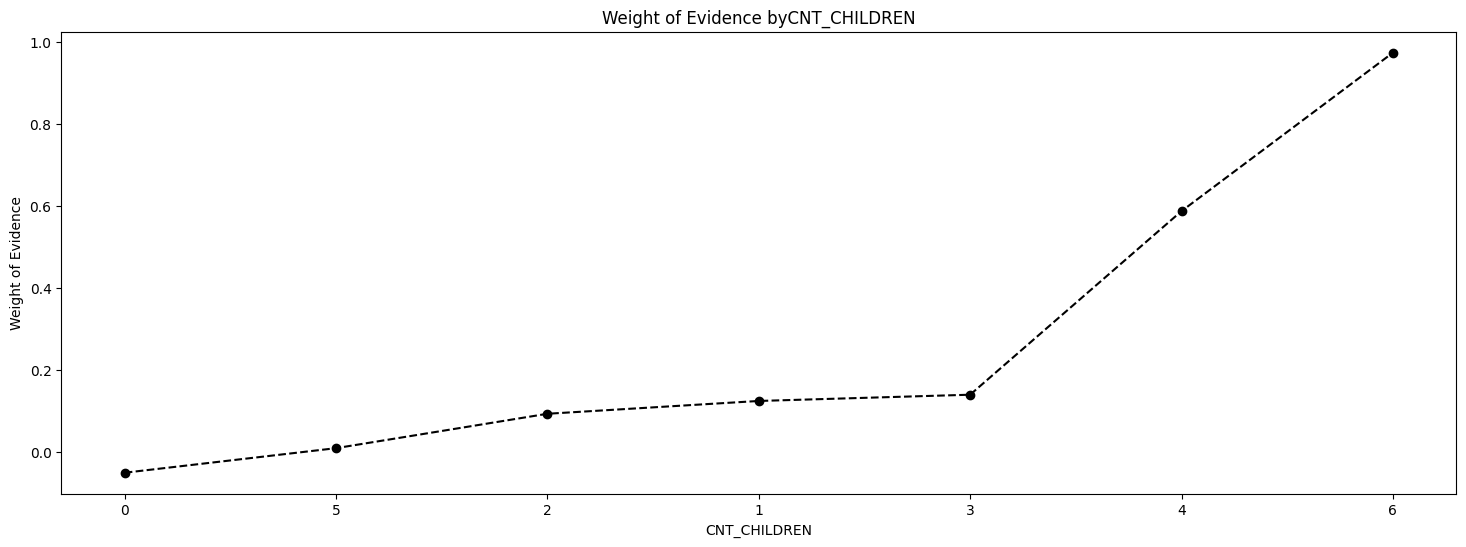

In [57]:
tempdata = discrete_woe(X_train_c3, 'CNT_CHILDREN', y_train)
display(tempdata)
plot_woe(tempdata)

### continuous feature

In [60]:
# function to woe continuous variable
def woe_continous(data, continous_col, y_data):
    data = pd.concat([data[continous_col], y_data], axis=1)
    data = pd.concat([data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].count(),
                      data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].mean()], axis=1)
    data = data.iloc[:, [0, 1, 3]]
    data.columns = [data.columns.values[0], 'n_obs', 'prop_good']
    data['prop_n_obs'] = data['n_obs'] / data['n_obs'].sum()
    data['n_good'] = data['prop_good'] * data['n_obs']
    data['n_bad'] = (1 - data['prop_good']) * data['n_obs']
    data['prop_n_good'] = data['n_good'] / data['n_good'].sum()
    data['prop_n_bad'] = data['n_bad'] / data['n_bad'].sum()
    data['WoE'] = np.log(data['prop_n_good'] / data['prop_n_bad'])
    data = data.sort_values(['WoE'])
    data = data.reset_index(drop=True)
    data['diff_prop_good'] = data['prop_good'].diff().abs()
    data['diff_WoE'] = data['WoE'].diff().abs()
    data['IV'] = (data['prop_n_good'] - data['prop_n_bad']) * data['WoE']
    data['IV'] = data['IV'].sum()
    return data


,AMT_INCOME_TOTAL,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,144900.0,32,0.0,2.983366e-05,0.0,32.0,0.000000,0.000033,-inf,NaN,NaN,inf
1,180234.0,3,0.0,2.796906e-06,0.0,3.0,0.000000,0.000003,-inf,0.0,NaN,inf
2,180090.0,5,0.0,4.661509e-06,0.0,5.0,0.000000,0.000005,-inf,0.0,NaN,inf
3,179550.0,2,0.0,1.864604e-06,0.0,2.0,0.000000,0.000002,-inf,0.0,NaN,inf
4,179271.0,4,0.0,3.729207e-06,0.0,4.0,0.000000,0.000004,-inf,0.0,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
2281,173520.0,4,1.0,3.729207e-06,4.0,0.0,0.000043,0.000000,inf,0.0,NaN,inf
2282,174748.5,8,1.0,7.458415e-06,8.0,0.0,0.000086,0.000000,inf,0.0,NaN,inf
2283,177448.5,1,1.0,9.323018e-07,1.0,0.0,0.000011,0.000000,inf,0.0,NaN,inf
2284,149553.0,1,1.0,9.323018e-07,1.0,0.0,0.000011,0.000000,inf,0.0,NaN,inf


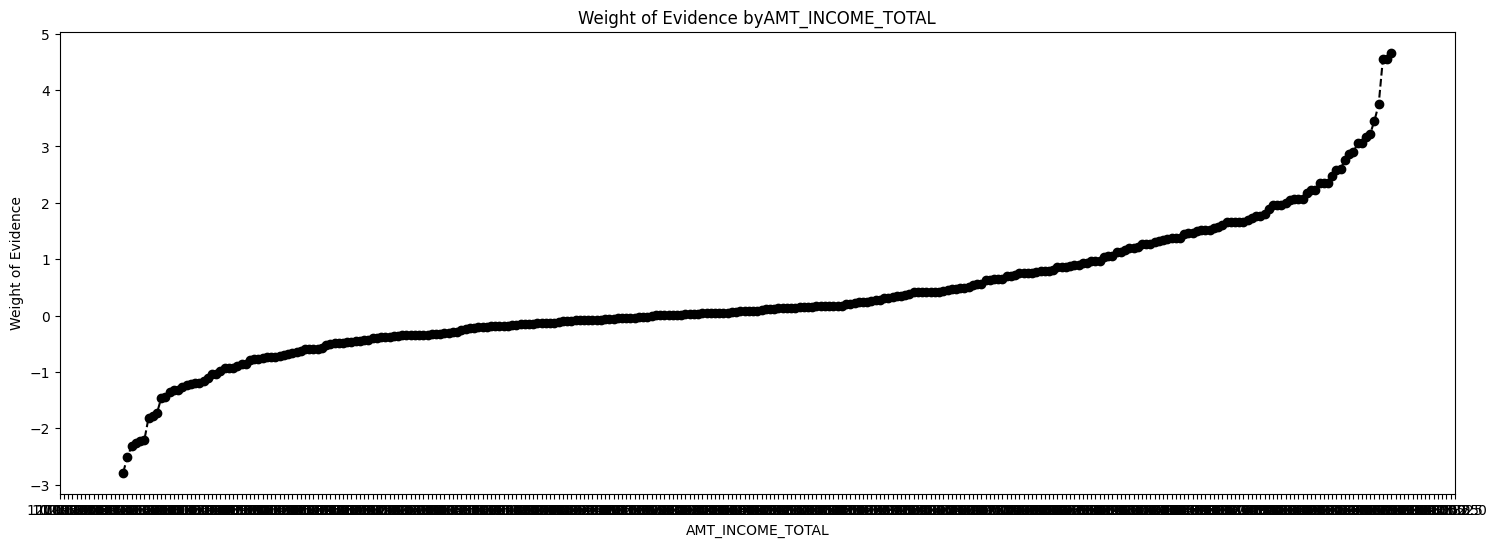

In [61]:
tempdata = woe_continous(X_train_c3, 'AMT_INCOME_TOTAL', y_train)
display(tempdata)
plot_woe(tempdata)

## Model Building

In [46]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the training data
    y_train_pred = model.predict(X_train)
    
    # Make predictions on the testing data
    y_test_pred = model.predict(X_test)
    
    # Calculate the accuracy for the training and testing data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Calculate the precision for the training and testing data
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    # Calculate the recall for the training and testing data
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    # Calculate the F1 score for the training and testing data
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Calculate the ROC AUC for the training and testing data
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
    return {
        'model': model.__class__.__name__,
        'train_recall': round(train_recall, 2),
        'test_recall': round(test_recall, 2),
        'train_roc_auc': round(train_roc_auc, 2),
        'test_roc_auc': round(test_roc_auc, 2)
    }

In [60]:
# import xgboost model
from xgboost import XGBClassifier

# import gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

lr = LogisticRegression(random_state=1103, class_weight='balanced')
xgb = XGBClassifier(random_state=1103)
gbc = GradientBoostingClassifier(random_state=1103)

models = [lr, xgb]

results = [evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test) for model in models]

# Convert the results to a DataFrame
df_model = pd.DataFrame(results)

In [61]:
df_model

,model,train_recall,test_recall,train_roc_auc,test_roc_auc
0,LogisticRegression,0.64,0.65,0.64,0.58
1,XGBClassifier,0.07,0.06,0.53,0.53


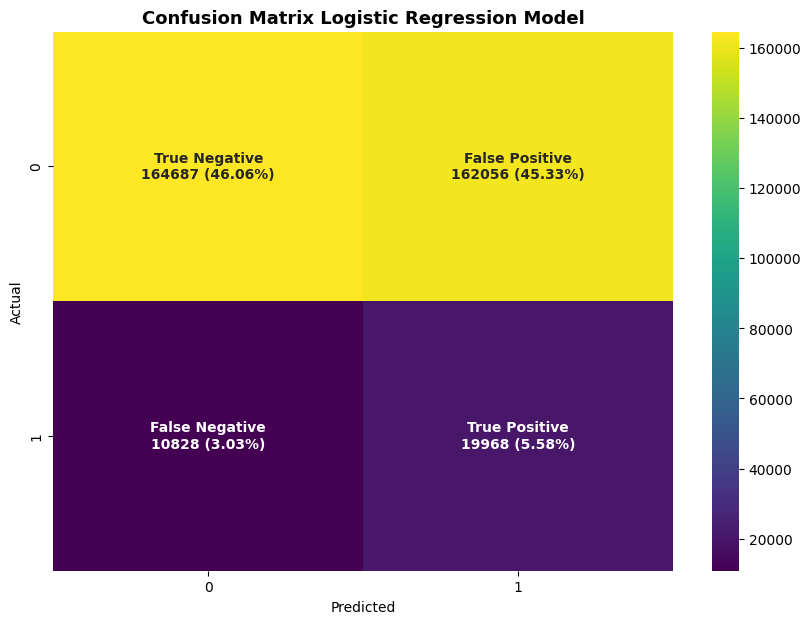

In [53]:
# Assuming X_test is your test dataset and model is your Gradient Boosting model
y_pred = lr.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.show()

## WoE and IV

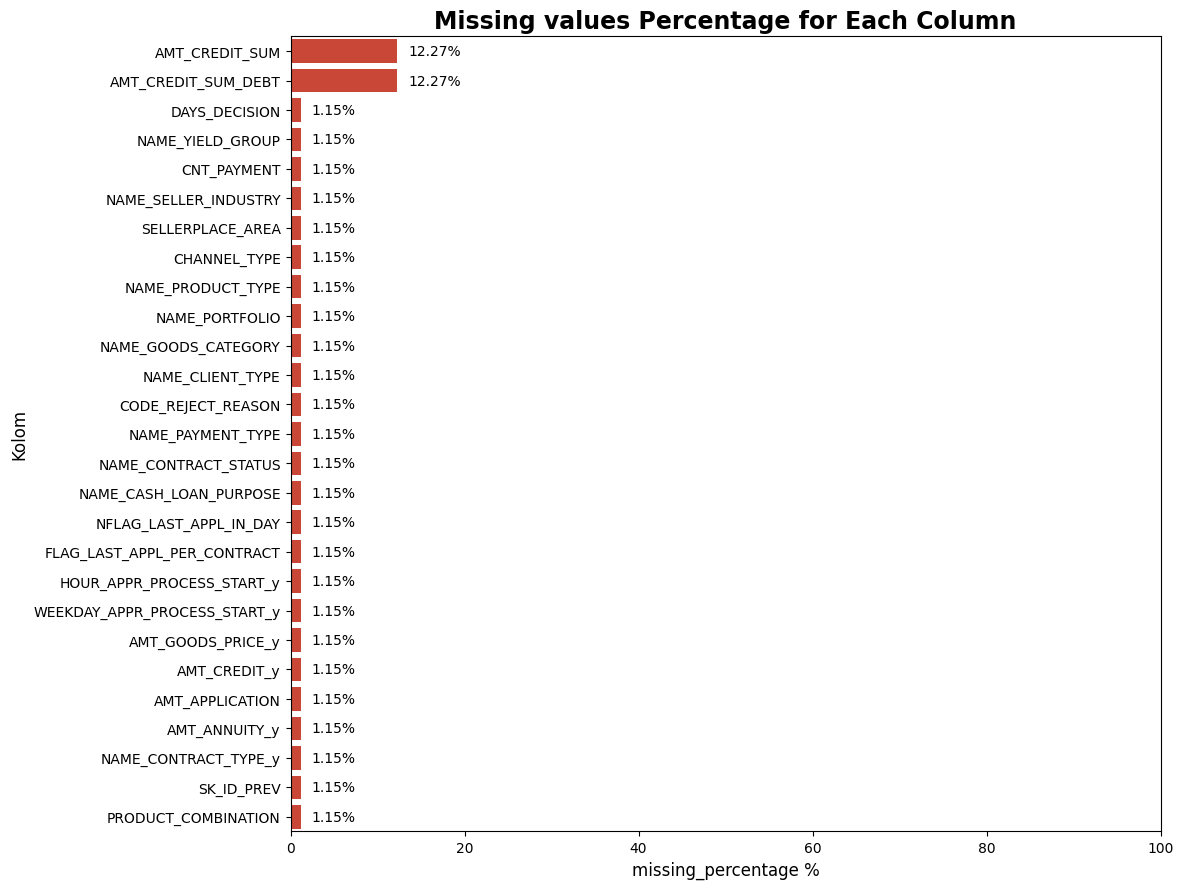

In [ ]:
ms.plot_missing_percentage(train_clean2)